In [22]:
# Load d3blocks
from d3blocks import D3Blocks

# Initialize
d3 = D3Blocks()

# Load example data
df = d3.import_example('energy')

# Plot
d3.sankey(df, filepath='sankey.html')

ModuleNotFoundError: No module named 'd3blocks'

In [23]:
df

NameError: name 'df' is not defined

In [25]:
import pandas as pd

self_df = pd.DataFrame(
    {
        'source': ['A', 'B', 'C', 'D', 'I'],
        'target': ['G', 'H', 'I', 'J', 'J'],
        'weight': [2, 2, 1, 1, 1]
    }
)

d3.sankey(self_df, filepath='sankey.html')

NameError: name 'd3' is not defined

In [170]:
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

sys.path.append(str(Path.cwd().parent / 'scripts'))
from _helpers import classify_north_south

idx = pd.IndexSlice

In [171]:
day = '2022-07-22'

In [172]:
# rev_path = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_flex_{}.csv')
rev_path = str(Path.cwd().parent / 'results' / f'{day}' / 'bmu_revenues_flex_{}.csv')

rev_national = pd.read_csv(rev_path.format('national'), index_col=0, header=[0,1,2], parse_dates=True).sum().mul(1e-6)
rev_zonal = pd.read_csv(rev_path.format('zonal'), index_col=0, header=[0,1,2], parse_dates=True).sum().mul(1e-6)

In [173]:
rev_national = pd.concat((
    rev_national.loc[idx[:, ['wind', 'disp', 'hydro', 'storage'], :]],
    pd.Series(rev_national.loc[idx[:, 'intercon', :]].sum(), index=pd.MultiIndex.from_tuples([('total', 'interconnector', 'wholesale')]))
))

rev_zonal = pd.concat((
    rev_zonal.loc[idx[:, ['wind', 'disp', 'hydro', 'storage'], :]],
    pd.Series(rev_zonal.loc[idx[:, 'intercon', :]].sum(), index=pd.MultiIndex.from_tuples([('total', 'interconnector', 'wholesale')]))
))

In [174]:
cost_summary = pd.read_csv(
    Path.cwd().parent / 'results' / f'{day}' / 'system_cost_summary_flex.csv', 
    index_col=[0,1],
    parse_dates=[0]
    )

cost_summary.head()

nodal     zonal  national
snapshot                                                         
2022-07-21 23:00:00 wholesale        3.024310  3.018061  3.018061
                    congestion_rent -0.034638 -0.000000  0.000000
                    cfd_payments    -0.069451 -0.069140 -0.069140
                    roc_payments     0.061326  0.061326  0.061326
                    offer_cost       0.000000  0.008303  0.008303

In [175]:
mp = pd.read_csv(
    Path.cwd().parent / 'results' / f'{day}' / 'marginal_prices_flex.csv',
    index_col=0,
    parse_dates=[0],
    header=[0,1]
    )

In [176]:
idx = pd.IndexSlice

buses = mp.loc[:,idx['zonal',:]].columns.get_level_values(1)

In [177]:
weights = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'load_weights.csv', index_col=0)

weights = weights.loc[buses.astype(int)]
weights /= weights.sum()

In [178]:
load = pd.read_csv(
    Path.cwd().parent / 'results' / f'{day}' / 'gb_total_load_flex.csv',
    index_col=0,
    parse_dates=[0]
).rename(columns={'0': 'load'})

load = pd.DataFrame(
    np.outer(load.values, weights.values),
    index=load.index,
    columns=weights.index.astype(str)
    )

load.head()

Bus,4950,4951,4952,4953,4955,4956,4958,4960,4961,4962,...,8515,8529,8565,8575,8578,8649,8744,8747,8838,8860
snapshot,,,,,,,,,,,,,,,,,,,,,
2022-07-21 23:00:00,102.157071,92.522278,91.885239,90.594767,81.147620,139.781862,68.334422,39.814142,55.418409,141.115608,...,201.503383,203.366114,20.855174,192.188464,138.874392,129.553317,12.302102,131.972874,82.343258,117.013057
2022-07-21 23:30:00,101.051524,91.520999,90.890854,89.614347,80.269438,138.269138,67.594905,39.383272,54.818669,139.588451,...,199.322707,201.165280,20.629479,190.108594,137.371489,128.151287,12.168968,130.544659,81.452136,115.746737
2022-07-22 00:00:00,97.610752,88.404739,87.796049,86.563008,77.536289,133.561118,65.293320,38.042284,52.952111,134.835509,...,192.535833,194.315667,19.927052,183.635458,132.694034,123.787777,11.754619,126.099655,78.678717,111.805598
2022-07-22 00:30:00,97.111084,87.952196,87.346623,86.119893,77.139382,132.877422,64.959085,37.847546,52.681050,134.145288,...,191.550245,193.320968,19.825045,182.695431,132.014776,123.154109,11.694447,125.454154,78.275962,111.233267
2022-07-22 01:00:00,94.955182,85.999625,85.407495,84.207999,75.426859,129.927493,63.516969,37.007317,51.511511,131.167213,...,187.297758,189.029170,19.384922,178.639524,129.083998,120.420042,11.434826,122.669024,76.538207,108.763847


In [179]:
network = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_nodal.nc'
)
buses = network.buses[['x', 'y']]
buses.loc[:, ['region']] = buses.apply(lambda x: classify_north_south(x['x'], x['y']), axis=1)

INFO:pypsa.io:Imported network network_flex_s_nodal.nc has buses, carriers, generators, links, loads, storage_units


In [180]:
north_loads = load.loc[:, buses.loc[buses.region == 'north'].index]
south_loads = load.loc[:, buses.loc[buses.region == 'south'].index.intersection(load.columns)]

print(north_loads.shape)
print(south_loads.shape)

(48, 60)
(48, 224)


In [181]:
import warnings
warnings.filterwarnings('ignore')

def get_wholesale_costs(mp, loads, mode):

    idx = pd.IndexSlice

    if mode == 'national':
        return np.inner(
            loads.sum(axis=1).values,
            mp.loc[:,idx['national', 'GB']].values
            ) * 0.5
        
    elif mode == 'zonal':
        total = 0
        for col in loads.columns:
            total += np.inner(
                loads.loc[:,col].values,
                mp.loc[:,idx['zonal', col]].values
                )
        return total * 0.5


costs = pd.Series(0, # is in units M£
    index=pd.MultiIndex.from_product([
        ['wholesale'],
        ['north', 'south'],
        ['national', 'zonal']
        ]
    ).append(
        pd.MultiIndex.from_product([
            ['roc', 'cfd', 'bids', 'offers', 'cfd'],
            ['socialised'],
            ['national', 'zonal']
            ]
        )
    )
)

costs.loc[idx['wholesale', 'north', 'national']] = get_wholesale_costs(mp, north_loads, 'national') * 1e-6
costs.loc[idx['wholesale', 'south', 'national']] = get_wholesale_costs(mp, south_loads, 'national') * 1e-6
costs.loc[idx['wholesale', 'north', 'zonal']] = get_wholesale_costs(mp, north_loads, 'zonal') * 1e-6
costs.loc[idx['wholesale', 'south', 'zonal']] = get_wholesale_costs(mp, south_loads, 'zonal') * 1e-6

costs.loc[idx['roc', 'socialised', 'national']] = cost_summary.loc[idx[:, 'roc_payments'], 'national'].sum()
costs.loc[idx['cfd', 'socialised', 'national']] = cost_summary.loc[idx[:, 'cfd_payments'], 'national'].sum()
costs.loc[idx['bids', 'socialised', 'national']] = cost_summary.loc[idx[:, 'bid_cost'], 'national'].sum()
costs.loc[idx['offers', 'socialised', 'national']] = cost_summary.loc[idx[:, 'offer_cost'], 'national'].sum()
costs.loc[idx['cfd', 'socialised', 'national']] = cost_summary.loc[idx[:, 'cfd_payments'], 'national'].sum()

costs.loc[idx['roc', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'roc_payments'], 'zonal'].sum()
costs.loc[idx['cfd', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'cfd_payments'], 'zonal'].sum()
costs.loc[idx['bids', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'bid_cost'], 'zonal'].sum()
costs.loc[idx['offers', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'offer_cost'], 'zonal'].sum()
costs.loc[idx['cfd', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'cfd_payments'], 'zonal'].sum()

costs

wholesale  north       national      6.550780
                       zonal         6.550780
           south       national    192.823569
                       zonal       192.823569
roc        socialised  national      2.927434
                       zonal         2.927434
cfd        socialised  national     -4.026601
                       zonal        -4.026601
bids       socialised  national     -0.108988
                       zonal        -0.108988
offers     socialised  national      0.284674
                       zonal         0.284674
cfd        socialised  national     -4.026601
                       zonal        -4.026601
dtype: float64

In [182]:
def get_consumer_box_limits(costs, mode, gap):

    box1 = costs.loc[idx['wholesale', 'north', mode]].sum()
    box2 = costs.loc[idx['wholesale', 'south', mode]].sum()
    box3 = costs.loc[idx[:, 'socialised', mode]].sum()

    total = box1 + box2 + box3

    box1 = box1 / total
    box2 = box2 / total
    box3 = box3 / total

    box1_upper = 1
    box1_lower = box1_upper - box1

    box2_upper = box1_lower - gap
    box2_lower = box2_upper - box2

    box3_upper = box2_lower - gap
    box3_lower = box3_upper - box3

    return (
        (box1_upper, box1_lower),
        (box2_upper, box2_lower),
        (box3_upper, box3_lower)
    )


gap = 0.02
box_width = 0.03
left_end = 0.
right_end = 1.

con_n, con_z, soc = get_consumer_box_limits(costs, 'national', gap)

In [183]:
def get_generator_box_limits(revs, gap):

    box_heights = {}

    revs = revs.copy() / revs.sum()

    for region, carrier in zip(revs.index.get_level_values(0), revs.index.get_level_values(1)):

        box_heights[(region, carrier)] = revs.loc[idx[region, carrier, :]].sum()

    box_upper = {}
    box_lower = {}

    box_upper[('north', 'wind')] = 1
    box_lower[('north', 'wind')] = box_upper[('north', 'wind')] - box_heights[('north', 'wind')]

    box_upper[('north', 'disp')] = box_lower[('north', 'wind')] - gap
    box_lower[('north', 'disp')] = box_upper[('north', 'disp')] - box_heights[('north', 'disp')]

    box_upper[('north', 'hydro')] = box_lower[('north', 'disp')] - gap
    box_lower[('north', 'hydro')] = box_upper[('north', 'hydro')] - box_heights[('north', 'hydro')]

    box_upper[('north', 'storage')] = box_lower[('north', 'hydro')] - gap
    box_lower[('north', 'storage')] = box_upper[('north', 'storage')] - box_heights[('north', 'storage')]

    box_upper[('south', 'wind')] = box_lower[('north', 'storage')] - gap
    box_lower[('south', 'wind')] = box_upper[('south', 'wind')] - box_heights[('south', 'wind')]

    box_upper[('south', 'disp')] = box_lower[('south', 'wind')] - gap
    box_lower[('south', 'disp')] = box_upper[('south', 'disp')] - box_heights[('south', 'disp')]

    box_upper[('south', 'hydro')] = box_lower[('south', 'disp')] - gap
    box_lower[('south', 'hydro')] = box_upper[('south', 'hydro')] - box_heights[('south', 'hydro')]

    box_upper[('south', 'storage')] = box_lower[('south', 'hydro')] - gap
    box_lower[('south', 'storage')] = box_upper[('south', 'storage')] - box_heights[('south', 'storage')]

    box_upper[('total', 'interconnector')] = box_lower[('south', 'storage')] - gap
    box_lower[('total', 'interconnector')] = box_upper[('total', 'interconnector')] - box_heights[('total', 'interconnector')]

    return box_lower, box_upper

rev_lowers, rev_uppers = get_generator_box_limits(rev_national, gap)

In [184]:
rev_flows = rev_national.copy() / rev_national.sum()


In [185]:
con_n

(1, 0.9663067795865647)

In [186]:
# Helper function to draw curved flow paths
def bezier_path(start, end, turning_ratio, num_samples=100):
    """
    Creates a smooth cubic Bézier curve as a NumPy array of points,
    suitable for use in Sankey diagrams.

    Parameters:
        start (tuple or list): (x, y) coordinates for the starting point.
        end (tuple or list): (x, y) coordinates for the ending point.
        turning_ratio (float): A value between 0 and 1 that defines the x-position
                               of the turning point. A value of 0 means the turning
                               point is at the start's x-coordinate, while 1 is at the end's.
        num_samples (int): The number of points to sample along the curve.

    Returns:
        numpy.ndarray: An array of shape (num_samples, 2) with the (x, y) coordinates of the curve.
    """
    # Convert start and end to NumPy arrays
    start = np.array(start, dtype=float)
    end = np.array(end, dtype=float)
    
    # Compute the common x-coordinate for both control points based on turning_ratio
    cp_x = start[0] + turning_ratio * (end[0] - start[0])
    
    # Define control points
    cp1 = np.array([cp_x, start[1]])
    cp2 = np.array([cp_x, end[1]])
    
    # Create an array of parameter values t in [0, 1]
    t = np.linspace(0, 1, num_samples).reshape(-1, 1)  # shape (num_samples, 1)
    one_minus_t = 1 - t

    # Evaluate the cubic Bézier curve at each t using the formula:
    # B(t) = (1-t)^3 * P0 + 3*(1-t)^2*t * P1 + 3*(1-t)*t^2 * P2 + t^3 * P3
    curve = (one_minus_t**3) * start + \
            3 * (one_minus_t**2) * t * cp1 + \
            3 * one_minus_t * (t**2) * cp2 + \
            (t**3) * end

    return curve[:,0], curve[:,1]

In [187]:
con_n

(1, 0.9663067795865647)

In [188]:
rev_uppers

{('north', 'wind'): 1,
 ('north', 'disp'): 0.9647785058023423,
 ('north', 'hydro'): 0.8952461054223562,
 ('north', 'storage'): 0.8604372144140447,
 ('south', 'wind'): 0.8398076152737074,
 ('south', 'disp'): 0.7766048539619006,
 ('south', 'hydro'): -0.07074548696335102,
 ('south', 'storage'): -0.09124986879888497,
 ('total', 'interconnector'): -0.11378623239787261}

In [189]:
soc

(-0.06546020789342465, -0.03999999999999997)

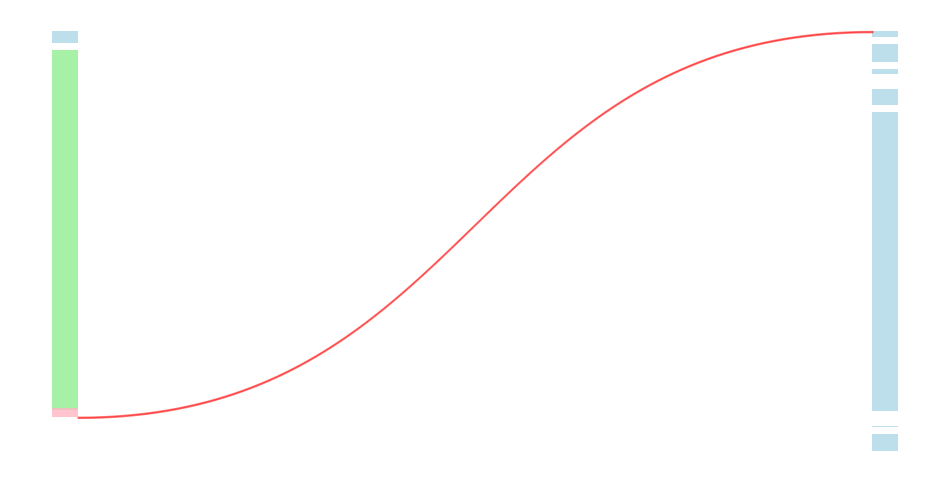

In [190]:
fig, ax = plt.subplots(figsize=(12, 6))

# Draw three rectangles on left side using box limits
ax.add_patch(plt.Rectangle((left_end, con_n[1]), box_width, con_n[0]-con_n[1], facecolor='lightblue', alpha=0.8))
ax.add_patch(plt.Rectangle((left_end, con_z[1]), box_width, con_z[0]-con_z[1], facecolor='lightgreen', alpha=0.8))
ax.add_patch(plt.Rectangle((left_end, soc[1]), box_width, soc[0]-soc[1], facecolor='lightpink', alpha=0.8))

for lower, upper in zip(rev_lowers.values(), rev_uppers.values()):
    ax.add_patch(plt.Rectangle((right_end - box_width, lower), box_width, upper-lower, facecolor='lightblue', alpha=0.8))



def add_flow(ax, left_upper, right_upper, box_width, volume, tp=0.5):

    start = (box_width, left_upper - volume/2)
    end = (1-box_width, right_upper - volume/2)

    x, y = bezier_path(start, end, tp)
    ax.fill_between(x, y-volume/2, y+volume/2, alpha=0.5, color='r')


add_flow(
    ax,
    soc[0],
    rev_uppers[('north', 'wind')],
    box_width,
    rev_flows.loc[idx['north', 'wind', 'roc']],
    )

ax.axis('off')
plt.show()

In [166]:
rev_uppers

{('north', 'wind'): 1,
 ('north', 'disp'): 0.6373634114479054,
 ('north', 'hydro'): 0.616861272342654,
 ('north', 'storage'): 0.5858894748202965,
 ('south', 'wind'): 0.5647625529746111,
 ('south', 'disp'): 0.1618262638915575,
 ('south', 'hydro'): -0.08766582736524565,
 ('south', 'storage'): -0.10787788701136596,
 ('total', 'interconnector'): -0.13217607451181007}

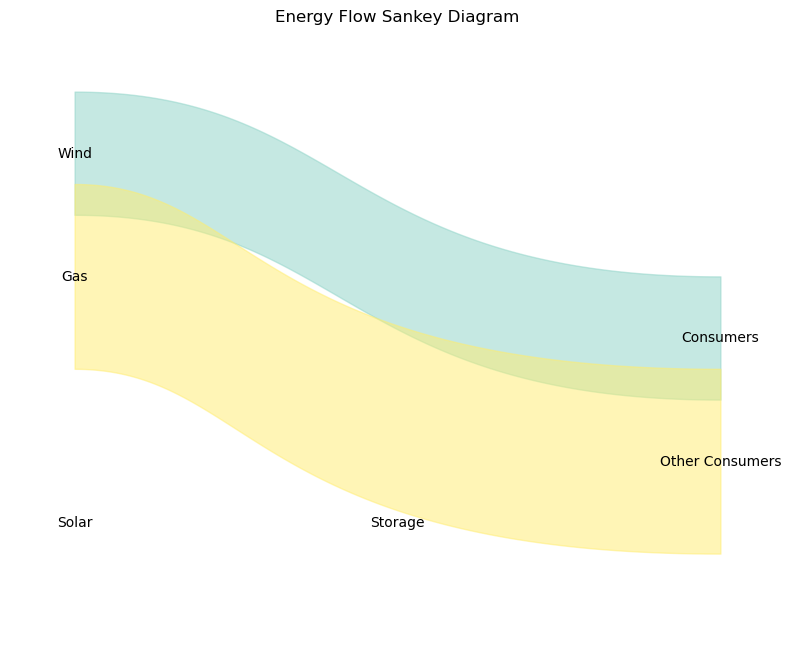

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create example Sankey data
nodes = ['Wind', 'Gas', 'Solar', 'Consumers', 'Storage']
flows = [
    ('Wind', 'Consumers', 0.2),
    ('Gas', 'Other Consumers', 0.3),
    # ('Solar', 'Storage', 20),
    # ('Storage', 'Consumers', 15),
]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Set node positions
node_pos = {
    'Wind': (0, 0.8),
    'Gas': (0, 0.6), 
    'Solar': (0, 0.2),
    'Storage': (0.5, 0.2),
    'Consumers': (1, 0.5),
    'Other Consumers': (1, 0.3)
}

# Draw flows
colors = plt.cm.Set3(np.linspace(0, 1, len(flows)))

for (source, target, value), color in zip(flows, colors):

    r = np.random.rand() * 0.5
    x, y = bezier_path(node_pos[source], node_pos[target], r)

    ax.fill_between(x, y-value/2, y+value/2, alpha=0.5, color=color)

# Draw nodes
for node, (x, y) in node_pos.items():
    ax.text(x, y, node, ha='center', va='center')

# Configure plot
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Energy Flow Sankey Diagram')

# plt.savefig('dummy_sankey.pdfk')
plt.show()

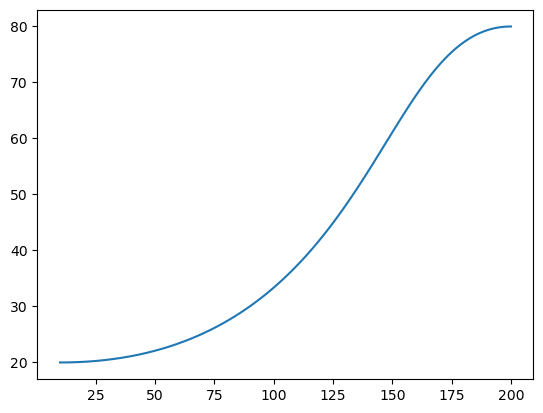

In [142]:
import numpy as np


# Example usage:
if __name__ == "__main__":
    start_point = (10, 20)
    end_point = (200, 80)
    turning_ratio = 0.7  # symmetric turning point along the x-axis
    bezier_points = create_bezier_curve(start_point, end_point, turning_ratio, num_samples=100)
    

    x = bezier_points[:,0]
    y = bezier_points[:,1]

    plt.plot(x, y)